In [1]:
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import lower, col, count, concat_ws
from pyspark.sql.types import Row
from pyspark import RDD
from typing import List, Tuple, Callable, Dict, Optional, Any, NamedTuple
import numpy as np
import scipy.stats as stats
from tqdm import tqdm

spark = (SparkSession.builder.appName("pacdb")
         .config("spark.executor.memory", "512M")
         .config("spark.sql.warehouse.dir", ".spark")
         .enableHiveSupport()
         .getOrCreate())

spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"

plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

24/03/14 12:07:51 WARN Utils: Your hostname, Chaitanyasumas-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.141.14.105 instead (on interface en0)
24/03/14 12:07:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/14 12:07:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Data Exploration

Source - https://archive.ics.uci.edu/dataset/320/student+performance 

In [2]:
math_df = spark.read.csv("./data/student_performance/student-mat.csv", header=True, inferSchema=True, sep=";")
portuguese_df = spark.read.csv("./data/student_performance/student-por.csv", header=True, inferSchema=True, sep=";")

In [3]:
math_df.printSchema()
math_df.show(5)

root
 |-- school: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- famsize: string (nullable = true)
 |-- Pstatus: string (nullable = true)
 |-- Medu: integer (nullable = true)
 |-- Fedu: integer (nullable = true)
 |-- Mjob: string (nullable = true)
 |-- Fjob: string (nullable = true)
 |-- reason: string (nullable = true)
 |-- guardian: string (nullable = true)
 |-- traveltime: integer (nullable = true)
 |-- studytime: integer (nullable = true)
 |-- failures: integer (nullable = true)
 |-- schoolsup: string (nullable = true)
 |-- famsup: string (nullable = true)
 |-- paid: string (nullable = true)
 |-- activities: string (nullable = true)
 |-- nursery: string (nullable = true)
 |-- higher: string (nullable = true)
 |-- internet: string (nullable = true)
 |-- romantic: string (nullable = true)
 |-- famrel: integer (nullable = true)
 |-- freetime: integer (nullable = true)
 |-- goout: integer (null

24/03/14 12:08:05 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+------+---+---+-------+-------+-------+----+----+-------+--------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|school|sex|age|address|famsize|Pstatus|Medu|Fedu|   Mjob|    Fjob|reason|guardian|traveltime|studytime|failures|schoolsup|famsup|paid|activities|nursery|higher|internet|romantic|famrel|freetime|goout|Dalc|Walc|health|absences| G1| G2| G3|
+------+---+---+-------+-------+-------+----+----+-------+--------+------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|    GP|  F| 18|      U|    GT3|      A|   4|   4|at_home| teacher|course|  mother|         2|        2|       0|      yes|    no|  no|        no|    yes|   yes|      no|      no|     4|       3|    4|   1|   1|     3|       6|  5|  6|  6|
|    GP|  F| 17|      U|    GT3|      T|

In [4]:
# portuguese_df.printSchema()
portuguese_df.show(10)

+------+---+---+-------+-------+-------+----+----+--------+--------+----------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|school|sex|age|address|famsize|Pstatus|Medu|Fedu|    Mjob|    Fjob|    reason|guardian|traveltime|studytime|failures|schoolsup|famsup|paid|activities|nursery|higher|internet|romantic|famrel|freetime|goout|Dalc|Walc|health|absences| G1| G2| G3|
+------+---+---+-------+-------+-------+----+----+--------+--------+----------+--------+----------+---------+--------+---------+------+----+----------+-------+------+--------+--------+------+--------+-----+----+----+------+--------+---+---+---+
|    GP|  F| 18|      U|    GT3|      A|   4|   4| at_home| teacher|    course|  mother|         2|        2|       0|      yes|    no|  no|        no|    yes|   yes|      no|      no|     4|       3|    4|   1|   1|     3|       4|  0| 11| 11|
|    GP|  F| 17|    

24/03/14 12:08:09 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


## Defining the Benchmark

Reference - 
[1] Garrido, G. M., Near, J., Muhammad, A., He, W., Matzutt, R., & Matthes, F. (2021). Do I get the privacy I need? Benchmarking utility in differential privacy libraries. arXiv preprint arXiv:2109.10789.

[1] defines two attributes as sensitive - _absence_days_ and _final_exam_grade_. They also state that - 

"To set the range bounds for the sensitivity calculation, we selected values based on the domain knowledge of the real-world datasets’ attributes, e.g., for the age attribute, we selected a lower bound and an upper bound of 0 and a 100 years, respectively."

We follow the same setup.

Test Queries for PAC-DB and PipelineDP
1. Count, Sum, Mean, Var
2.  

## Count

In [17]:
# Non-private query

defaulters = math_df.filter(math_df["absences"] >= 5) # More than 5 absent days
defaulters.count()

151

In [18]:
# Private Query

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions, BudgetAccountant
import paclib.mechanism
import math

user_defined_sampling_rate = 0.5
tau = 3
seeds =  list(range(tau))
budget_list = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]
m = 50
c = 1e-6

def create_pac_df(df, user_defined_sampling_rate, seed=None):

    pac_defaulters_df = (PACDataFrame(df)
                    .withSamplerOptions(
                        SamplerOptions(
                            withReplacement=False,                  # should be false given get_samples_safe() logic 
                                                                    #    - perhaps no custom input for this?
                            fraction=user_defined_sampling_rate,    # fixed sampling rate of 0.5
                            columns_to_sample_by=None,
                            seed=seed
                        )
                    ))
    return pac_defaulters_df

def estimate_noise(df, user_defined_sampling_rate, m, seeds=None):
    # for each trial, get Y1, Y2 and Y3 for every seed
    min_distances = []
    for _ in range(m): 
        y_1 = []
        y_2 = []
        # for seed in range(len(seeds)):
        pac_defaulters_df = create_pac_df(df, user_defined_sampling_rate, seed=None)
    
        # given X1 and X2 of the same seed, apply A(X) to produce Yi where i is the ith seed
        y_i_1 = (pac_defaulters_df.sample()
            .filter(df["absences"] >= 5)
            .count())
        y_i_2 = (pac_defaulters_df.sample()
        .filter(df["absences"] >= 5)
        .count())

        y_i_1 *= (1/user_defined_sampling_rate)
        y_i_2 *= (1/user_defined_sampling_rate)

        y_1.append(y_i_1)
        y_2.append(y_i_2)
            
        # find average minimum perturbation distance between y1 and y2 - the paper uses euclidean distance
        # for ind in range(tau):
        current_distance = np.linalg.norm(np.array(y_i_1) - np.array(y_i_2))
        print("Current distance ", current_distance)
        min_distances.append(current_distance)
        
    # Calculate average minimum perturbation distance
    avg_min_distance = np.mean(min_distances) # this will divide by m trials
    return avg_min_distance

avg_min_distance = estimate_noise(math_df, user_defined_sampling_rate, m)
print(avg_min_distance)


Current distance  2.0
Current distance  2.0
Current distance  6.0
Current distance  6.0
Current distance  26.0
Current distance  34.0
Current distance  8.0
Current distance  32.0
Current distance  22.0
Current distance  40.0
Current distance  4.0
Current distance  4.0
Current distance  10.0
Current distance  18.0
Current distance  0.0
Current distance  6.0
Current distance  10.0
Current distance  0.0
Current distance  28.0
Current distance  2.0
Current distance  14.0
Current distance  26.0
Current distance  32.0
Current distance  16.0
Current distance  18.0
Current distance  2.0
Current distance  32.0
Current distance  30.0
Current distance  10.0
Current distance  2.0
Current distance  10.0
Current distance  6.0
Current distance  30.0
Current distance  18.0
Current distance  14.0
Current distance  38.0
Current distance  2.0
Current distance  12.0
Current distance  18.0
Current distance  12.0
Current distance  16.0
Current distance  2.0
Current distance  10.0
Current distance  16.0
Curr

In [19]:
final_results = []
subsampled_error = []

defaulters = 151

for budget_item in budget_list:
    budget = BudgetAccountant(max_mi=budget_item)
    # using the distance, calculate exact noise as isotropic Gaussian noise with mean 0 
    # and variance as avg_min_distance
    noise = paclib.mechanism.noise_to_add(avg_min_distance, c, budget)

    # compute final sample for different mi's
    pac_defaulters_df = create_pac_df(math_df, user_defined_sampling_rate, seed=None)
    y_final = (pac_defaulters_df.sample()
                .filter(math_df["absences"] >= 5)
                .count())
    
    y_final *= (1/user_defined_sampling_rate)
    
    error_of_subsampled_defaulters = abs(defaulters - y_final)/defaulters
    subsampled_error.append(error_of_subsampled_defaulters)

    y_final += abs(noise)

    priv_defaulters = abs(defaulters - y_final)/defaulters

    final_results.append(y_final)

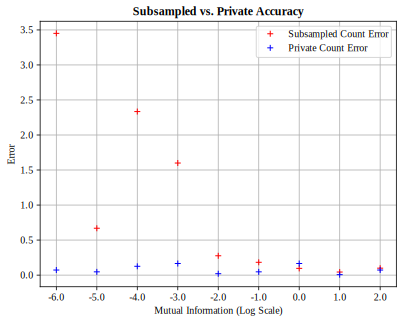

In [20]:
# Accuracy Plot
import math
private_count_error = []
for y in final_results:
    priv_defaulters = abs(defaulters - y)/defaulters
    private_count_error.append(priv_defaulters)

import matplotlib.pyplot as plt

# Plot
plt.figure()
plt.plot(budget_list, private_count_error, 'r+', label='Subsampled Count Error')  
plt.plot(budget_list, subsampled_error, 'b+', label='Private Count Error')

plt.xscale('log', base=2)
plt.xticks(budget_list, [format(np.log2(val)) for val in budget_list])

plt.xlabel('Mutual Information (Log Scale)')
plt.ylabel('Error')
folder_path = 'figs/student_performance'
plt.savefig(folder_path + '/count_error.png')
plt.title('Subsampled vs. Private Accuracy')
plt.legend()

plt.grid(True)
plt.show()



In [79]:
# # Step 3: Calculate Noise

# from pacdb import QueryRewriter, Aggregator
# trials = 200

# # filter = pac_defaulters_df.add_filter("math_df[\"absences\"] >= 5")
# # aggr = pac_defaulters_df.map_to_function("count")

# # samples = pac_defaulters_df.get_samples(pac_defaulters_df, user_defined_sampling_rate, filter, aggr, trials)
# sampled_counts = samples
# pairwise_differences = []

# for i in range(len(sampled_counts)):
#     for j in range(i + 1, len(sampled_counts)):
#         difference = sampled_counts[i] - sampled_counts[j]
#         pairwise_differences.append(difference)

In [81]:
# visualize change from the strict pairwise sampling to all pairwise sampling

## Sum

In [21]:
# Non-private query
from pyspark.sql.functions import sum as spark_sum

sum_result = math_df.filter(math_df["Mjob"] == "at_home").agg(spark_sum("studytime")).collect()
sum_of_x = sum_result[0]["sum(studytime)"]

print(sum_of_x)

124


In [22]:
# Private Query

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions, BudgetAccountant
import paclib.mechanism
import math

user_defined_sampling_rate = 0.5
tau = 3
seeds =  list(range(tau))
budget_list = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]
m = 50
c = 1e-6

def create_pac_df(df, user_defined_sampling_rate, seed=None):

    pac_defaulters_df = (PACDataFrame(df)
                    .withSamplerOptions(
                        SamplerOptions(
                            withReplacement=False,                  # should be false given get_samples_safe() logic 
                                                                    #    - perhaps no custom input for this?
                            fraction=user_defined_sampling_rate,    # fixed sampling rate of 0.5
                            columns_to_sample_by=None,
                            seed=seed
                        )
                    ))
    return pac_defaulters_df

def estimate_noise(df, user_defined_sampling_rate, m, seeds=None):
    # for each trial, get Y1, Y2 and Y3 for every seed
    min_distances = []
    for _ in range(m): 
        y_1 = []
        y_2 = []
        print("trial ", _)
        # for seed in range(len(seeds)):
        pac_defaulters_df = create_pac_df(df, user_defined_sampling_rate, seed=None)
    
        # given X1 and X2 of the same seed, apply A(X) to produce Yi where i is the ith seed
        y_i_1 = (pac_defaulters_df.sample()
            .filter(df["Mjob"] == "at_home")
            .agg(spark_sum("studytime"))).collect()
        y_i_2 = (pac_defaulters_df.sample()
                .filter(df["Mjob"] == "at_home")
                .agg(spark_sum("studytime"))).collect()

        y_i_1 = y_i_1[0]["sum(studytime)"]
        y_i_2 = y_i_2[0]["sum(studytime)"]

        y_i_1 *= (1/user_defined_sampling_rate)
        y_i_2 *= (1/user_defined_sampling_rate)

        print("For current trial ", _, " the values are ", y_i_1, y_i_2)

        y_1.append(y_i_1)
        y_2.append(y_i_2)
            
        # find average minimum perturbation distance between y1 and y2 - the paper uses euclidean distance
        # for ind in range(tau):
        current_distance = np.linalg.norm(np.array(y_i_1) - np.array(y_i_2))
        print("Current distance ", current_distance)
        min_distances.append(current_distance)
        
    # Calculate average minimum perturbation distance
    avg_min_distance = np.mean(min_distances) # this will divide by m trials
    return avg_min_distance

avg_min_distance = estimate_noise(math_df, user_defined_sampling_rate, m)
print(avg_min_distance)


trial  0
For current trial  0  the values are  156.0 128.0
Current distance  28.0
trial  1
For current trial  1  the values are  104.0 140.0
Current distance  36.0
trial  2
For current trial  2  the values are  126.0 126.0
Current distance  0.0
trial  3
For current trial  3  the values are  126.0 128.0
Current distance  2.0
trial  4
For current trial  4  the values are  128.0 142.0
Current distance  14.0
trial  5
For current trial  5  the values are  134.0 156.0
Current distance  22.0
trial  6
For current trial  6  the values are  156.0 128.0
Current distance  28.0
trial  7
For current trial  7  the values are  138.0 172.0
Current distance  34.0
trial  8
For current trial  8  the values are  114.0 120.0
Current distance  6.0
trial  9
For current trial  9  the values are  136.0 114.0
Current distance  22.0
trial  10
For current trial  10  the values are  134.0 112.0
Current distance  22.0
trial  11
For current trial  11  the values are  102.0 164.0
Current distance  62.0
trial  12
For c

In [23]:
final_results = []
subsampled_error = []

actual_result = 124

for budget_item in budget_list:
    budget = BudgetAccountant(max_mi=budget_item)
    print("For current MI value,", budget_item)
    # using the distance, calculate exact noise as isotropic Gaussian noise with mean 0 and variance as avg_min_distance
    noise = paclib.mechanism.noise_to_add(avg_min_distance, c, budget)
    print("Noise computed to be - ", noise)

    # compute final sample for different mi's
    pac_defaulters_df = create_pac_df(math_df, user_defined_sampling_rate, seed=None)
    
    y_final = (pac_defaulters_df.sample()
                .filter(math_df["Mjob"] == "at_home")
                .agg(spark_sum("studytime"))).collect()

    y_final = y_final[0]["sum(studytime)"]
    
    y_final *= (1/user_defined_sampling_rate)

    print("subsampled count is ", y_final)
    
    error_of_subsampled = abs(actual_result - y_final)/actual_result
    subsampled_error.append(error_of_subsampled)

    y_final += abs(noise)
    print("private count is ", y_final)

    final_results.append(y_final)

For current MI value, 0.015625
Noise computed to be -  -343.19913105669093
subsampled count is  136.0
private count is  479.19913105669093
For current MI value, 0.03125
Noise computed to be -  41.70170693214632
subsampled count is  114.0
private count is  155.70170693214632
For current MI value, 0.0625
Noise computed to be -  364.1205250126168
subsampled count is  138.0
private count is  502.1205250126168
For current MI value, 0.125
Noise computed to be -  -61.34373186720333
subsampled count is  118.0
private count is  179.34373186720333
For current MI value, 0.25
Noise computed to be -  -1.0037224073669928
subsampled count is  100.0
private count is  101.003722407367
For current MI value, 0.5
Noise computed to be -  -13.037219435442426
subsampled count is  98.0
private count is  111.03721943544242
For current MI value, 1.0
Noise computed to be -  15.271483998721925
subsampled count is  122.0
private count is  137.27148399872192
For current MI value, 2.0
Noise computed to be -  24.0201

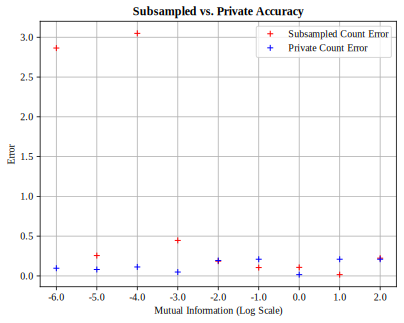

In [24]:
# Accuracy Plot
import math
private_error = []
for y in final_results:
    priv_result = abs(actual_result - y)/actual_result
    private_error.append(priv_result)

import matplotlib.pyplot as plt

# Plot
plt.figure()
plt.plot(budget_list, private_error, 'r+', label='Subsampled Count Error')  
plt.plot(budget_list, subsampled_error, 'b+', label='Private Count Error')

plt.xscale('log', base=2)
plt.xticks(budget_list, [format(np.log2(val)) for val in budget_list])

plt.xlabel('Mutual Information (Log Scale)')
plt.ylabel('Error')
folder_path = 'figs/student_performance'
plt.savefig(folder_path + '/sum_error.png')
plt.title('Subsampled vs. Private Accuracy')
plt.legend()

plt.grid(True)
plt.show()



## Singular result

In [25]:
# Non-private query
from pyspark.sql.functions import sum as spark_sum

singular_result_set = math_df.filter((math_df["absences"] > 20) & (math_df["Mjob"] == "at_home")).count()

print(singular_result_set)

1


In [26]:
# Private Query

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions, BudgetAccountant
import paclib.mechanism
import math

user_defined_sampling_rate = 0.5
tau = 3
seeds =  list(range(tau))
budget_list = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]
m = 50
c = 1e-6

def create_pac_df(df, user_defined_sampling_rate, seed=None):

    pac_defaulters_df = (PACDataFrame(df)
                    .withSamplerOptions(
                        SamplerOptions(
                            withReplacement=False,                  # should be false given get_samples_safe() logic 
                                                                    #    - perhaps no custom input for this?
                            fraction=user_defined_sampling_rate,    # fixed sampling rate of 0.5
                            columns_to_sample_by=None,
                            seed=seed
                        )
                    ))
    return pac_defaulters_df

def estimate_noise(df, user_defined_sampling_rate, m, seeds=None):
    # for each trial, get Y1, Y2 and Y3 for every seed
    min_distances = []
    for _ in range(m): 
        y_1 = []
        y_2 = []
        print("trial ", _)
        # for seed in range(len(seeds)):
        pac_defaulters_df = create_pac_df(df, user_defined_sampling_rate, seed=None)
    
        # given X1 and X2 of the same seed, apply A(X) to produce Yi where i is the ith seed
        y_i_1 = (pac_defaulters_df.sample()
            .filter((df["absences"] > 20) & (df["Mjob"] == "at_home"))).count()
        y_i_2 = (pac_defaulters_df.sample()
            .filter((df["absences"] > 20) & (df["Mjob"] == "at_home"))).count()

        y_i_1 *= (1/user_defined_sampling_rate)
        y_i_2 *= (1/user_defined_sampling_rate)

        print("For current trial ", _, " the values are ", y_i_1, y_i_2)

        y_1.append(y_i_1)
        y_2.append(y_i_2)
            
        # find average minimum perturbation distance between y1 and y2 - the paper uses euclidean distance
        # for ind in range(tau):
        current_distance = np.linalg.norm(np.array(y_i_1) - np.array(y_i_2))
        print("Current distance ", current_distance)
        min_distances.append(current_distance)
        
    # Calculate average minimum perturbation distance
    avg_min_distance = np.mean(min_distances) # this will divide by m trials
    return avg_min_distance

avg_min_distance = estimate_noise(math_df, user_defined_sampling_rate, m)
print(avg_min_distance)


trial  0
For current trial  0  the values are  0.0 2.0
Current distance  2.0
trial  1
For current trial  1  the values are  2.0 0.0
Current distance  2.0
trial  2
For current trial  2  the values are  0.0 0.0
Current distance  0.0
trial  3
For current trial  3  the values are  0.0 0.0
Current distance  0.0
trial  4
For current trial  4  the values are  0.0 0.0
Current distance  0.0
trial  5
For current trial  5  the values are  2.0 2.0
Current distance  0.0
trial  6
For current trial  6  the values are  0.0 0.0
Current distance  0.0
trial  7
For current trial  7  the values are  2.0 2.0
Current distance  0.0
trial  8
For current trial  8  the values are  2.0 0.0
Current distance  2.0
trial  9
For current trial  9  the values are  2.0 0.0
Current distance  2.0
trial  10
For current trial  10  the values are  0.0 0.0
Current distance  0.0
trial  11
For current trial  11  the values are  0.0 2.0
Current distance  2.0
trial  12
For current trial  12  the values are  2.0 0.0
Current distanc

In [27]:
final_results = []
subsampled_error = []

actual_result = 1

for budget_item in budget_list:
    budget = BudgetAccountant(max_mi=budget_item)
    print("For current MI value,", budget_item)
    # using the distance, calculate exact noise as isotropic Gaussian noise with mean 0 and variance as avg_min_distance
    noise = paclib.mechanism.noise_to_add(avg_min_distance, c, budget)
    print("Noise computed to be - ", noise)

    # compute final sample for different mi's
    pac_defaulters_df = create_pac_df(math_df, user_defined_sampling_rate, seed=None)
    
    y_final = (pac_defaulters_df.sample()
                .filter((math_df["absences"] > 20) & (math_df["Mjob"] == "at_home"))).count()
    
    y_final *= (1/user_defined_sampling_rate)

    print("subsampled count is ", y_final)
    
    error_of_subsampled = abs(actual_result - y_final)/actual_result
    subsampled_error.append(error_of_subsampled)

    y_final += abs(noise)
    print("private count is ", y_final)

    final_results.append(y_final)

For current MI value, 0.015625
Noise computed to be -  -68.21169817274021
subsampled count is  2.0
private count is  70.21169817274021
For current MI value, 0.03125
Noise computed to be -  -4.280284939045084
subsampled count is  2.0
private count is  6.280284939045084
For current MI value, 0.0625
Noise computed to be -  -1.5719534671401747
subsampled count is  0.0
private count is  1.5719534671401747
For current MI value, 0.125
Noise computed to be -  7.776909747091794
subsampled count is  0.0
private count is  7.776909747091794
For current MI value, 0.25
Noise computed to be -  -1.4152520440964556
subsampled count is  2.0
private count is  3.4152520440964556
For current MI value, 0.5
Noise computed to be -  2.366429381542156
subsampled count is  2.0
private count is  4.366429381542156
For current MI value, 1.0
Noise computed to be -  0.32986093921018433
subsampled count is  0.0
private count is  0.32986093921018433
For current MI value, 2.0
Noise computed to be -  0.3541314504937275
s

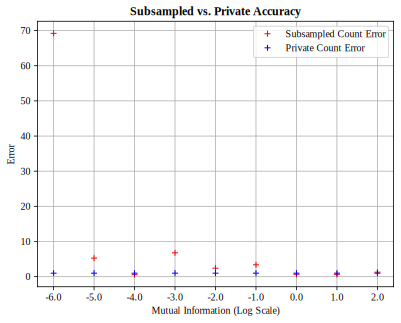

In [28]:
# Accuracy Plot
import math
private_error = []
for y in final_results:
    priv_result = abs(actual_result - y)/actual_result
    private_error.append(priv_result)

import matplotlib.pyplot as plt

# Plot
plt.figure()
plt.plot(budget_list, private_error, 'r+', label='Subsampled Count Error')  
plt.plot(budget_list, subsampled_error, 'b+', label='Private Count Error')

plt.xscale('log', base=2)
plt.xticks(budget_list, [format(np.log2(val)) for val in budget_list])

plt.xlabel('Mutual Information (Log Scale)')
plt.ylabel('Error')
folder_path = 'figs/student_performance'
plt.savefig(folder_path + '/singular_count_error.png')
plt.title('Subsampled vs. Private Accuracy')
plt.legend()

plt.grid(True)
plt.show()

# Question: Is this a violation of PAC? IMO, reconstruction hardness still holds


## Max

In [29]:
max_result = math_df.agg({"absences": "max"}).collect()[0][0]
print(max_result)

75


In [30]:
# Private Query

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions, BudgetAccountant
import paclib.mechanism
import math

user_defined_sampling_rate = 0.5
tau = 3
seeds =  list(range(tau))
budget_list = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]
m = 50
c = 1e-6

def create_pac_df(df, user_defined_sampling_rate, seed=None):

    pac_defaulters_df = (PACDataFrame(df)
                    .withSamplerOptions(
                        SamplerOptions(
                            withReplacement=False,                  # should be false given get_samples_safe() logic 
                                                                    #    - perhaps no custom input for this?
                            fraction=user_defined_sampling_rate,    # fixed sampling rate of 0.5
                            columns_to_sample_by=None,
                            seed=seed
                        )
                    ))
    return pac_defaulters_df

def estimate_noise(df, user_defined_sampling_rate, m, seeds=None):
    # for each trial, get Y1, Y2 and Y3 for every seed
    min_distances = []
    for _ in range(m): 
        y_1 = []
        y_2 = []
        print("trial ", _)
        # for seed in range(len(seeds)):
        pac_defaulters_df = create_pac_df(df, user_defined_sampling_rate, seed=None)
    
        # given X1 and X2 of the same seed, apply A(X) to produce Yi where i is the ith seed
        y_i_1 = (pac_defaulters_df.sample()
            .agg({"absences": "max"})).collect()[0][0]
        y_i_2 = (pac_defaulters_df.sample()
            .agg({"absences": "max"})).collect()[0][0]

        # y_i_1 *= (1/user_defined_sampling_rate)
        # y_i_2 *= (1/user_defined_sampling_rate)

        print("For current trial ", _, " the values are ", y_i_1, y_i_2)

        y_1.append(y_i_1)
        y_2.append(y_i_2)
            
        # find average minimum perturbation distance between y1 and y2 - the paper uses euclidean distance
        # for ind in range(tau):
        current_distance = np.linalg.norm(np.array(y_i_1) - np.array(y_i_2))
        print("Current distance ", current_distance)
        min_distances.append(current_distance)
        
    # Calculate average minimum perturbation distance
    avg_min_distance = np.mean(min_distances) # this will divide by m trials
    return avg_min_distance

avg_min_distance = estimate_noise(math_df, user_defined_sampling_rate, m)
print(avg_min_distance)


trial  0
For current trial  0  the values are  40 56
Current distance  16.0
trial  1
For current trial  1  the values are  56 24
Current distance  32.0
trial  2
For current trial  2  the values are  54 75
Current distance  21.0
trial  3
For current trial  3  the values are  75 56
Current distance  19.0
trial  4
For current trial  4  the values are  40 75
Current distance  35.0
trial  5
For current trial  5  the values are  75 75
Current distance  0.0
trial  6
For current trial  6  the values are  40 75
Current distance  35.0
trial  7
For current trial  7  the values are  54 56
Current distance  2.0
trial  8
For current trial  8  the values are  75 75
Current distance  0.0
trial  9
For current trial  9  the values are  56 56
Current distance  0.0
trial  10
For current trial  10  the values are  38 75
Current distance  37.0
trial  11
For current trial  11  the values are  75 54
Current distance  21.0
trial  12
For current trial  12  the values are  75 75
Current distance  0.0
trial  13
F

In [31]:
final_results = []
subsampled_error = []

actual_result = 75

for budget_item in budget_list:
    budget = BudgetAccountant(max_mi=budget_item)
    print("For current MI value,", budget_item)
    # using the distance, calculate exact noise as isotropic Gaussian noise with mean 0 and variance as avg_min_distance
    noise = paclib.mechanism.noise_to_add(avg_min_distance, c, budget)
    print("Noise computed to be - ", noise)

    # compute final sample for different mi's
    pac_defaulters_df = create_pac_df(math_df, user_defined_sampling_rate, seed=None)
    
    y_final = (pac_defaulters_df.sample()
                .agg({"absences": "max"})).collect()[0][0]

    print("subsampled count is ", y_final)
    
    error_of_subsampled = abs(actual_result - y_final)/actual_result
    subsampled_error.append(error_of_subsampled)

    y_final += abs(noise)
    print("private count is ", y_final)

    final_results.append(y_final)

For current MI value, 0.015625
Noise computed to be -  -480.1916146718403
subsampled count is  56
private count is  536.1916146718403
For current MI value, 0.03125
Noise computed to be -  53.59502896006063
subsampled count is  54
private count is  107.59502896006063
For current MI value, 0.0625
Noise computed to be -  -44.44647275442702
subsampled count is  75
private count is  119.44647275442702
For current MI value, 0.125
Noise computed to be -  13.448630874522193
subsampled count is  75
private count is  88.4486308745222
For current MI value, 0.25
Noise computed to be -  123.00070045542002
subsampled count is  75
private count is  198.00070045542003
For current MI value, 0.5
Noise computed to be -  13.92256524885053
subsampled count is  56
private count is  69.92256524885053
For current MI value, 1.0
Noise computed to be -  -1.7194474973750582
subsampled count is  56
private count is  57.71944749737506
For current MI value, 2.0
Noise computed to be -  20.389125341807254
subsampled c

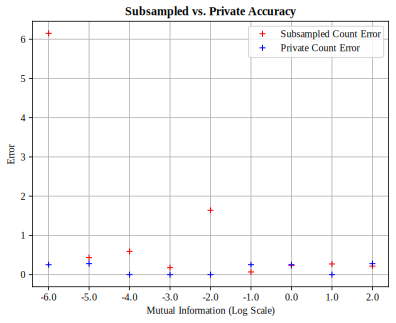

In [32]:
# Accuracy Plot
import math
private_error = []
for y in final_results:
    priv_result = abs(actual_result - y)/actual_result
    private_error.append(priv_result)

import matplotlib.pyplot as plt

# Plot
plt.figure()
plt.plot(budget_list, private_error, 'r+', label='Subsampled Count Error')  
plt.plot(budget_list, subsampled_error, 'b+', label='Private Count Error')

plt.xscale('log', base=2)
plt.xticks(budget_list, [format(np.log2(val)) for val in budget_list])

plt.xlabel('Mutual Information (Log Scale)')
plt.ylabel('Error')
folder_path = 'figs/student_performance'
plt.savefig(folder_path + '/max_error.png')
plt.title('Subsampled vs. Private Accuracy')
plt.legend()

plt.grid(True)
plt.show()

# Observation - the subsampled accuracy itself falls, but PAC holds...


## Aggregate Stats in case of skewed distribution

In [7]:
# Assuming 'df' is your DataFrame and 'column_name' is the name of the column containing "yes" and "no"
counts_df = math_df.groupBy("guardian").agg(count("*").alias("count"))

# Display the counts
counts_df.show()


+--------+-----+
|guardian|count|
+--------+-----+
|  father|   90|
|  mother|  273|
|   other|   32|
+--------+-----+



In [9]:
actual_result = math_df.filter(col("guardian") == "father").count()
print(actual_result)

90


In [10]:
# Private Query

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions, BudgetAccountant
import paclib.mechanism
import math

user_defined_sampling_rate = 0.5
tau = 3
seeds =  list(range(tau))
budget_list = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]
m = 50
c = 1e-6

def create_pac_df(df, user_defined_sampling_rate, seed=None):

    pac_defaulters_df = (PACDataFrame(df)
                    .withSamplerOptions(
                        SamplerOptions(
                            withReplacement=False,                  # should be false given get_samples_safe() logic 
                                                                    #    - perhaps no custom input for this?
                            fraction=user_defined_sampling_rate,    # fixed sampling rate of 0.5
                            columns_to_sample_by=None,
                            seed=seed
                        )
                    ))
    return pac_defaulters_df

def estimate_noise(df, user_defined_sampling_rate, m, seeds=None):
    # for each trial, get Y1, Y2 and Y3 for every seed
    min_distances = []
    for _ in range(m): 
        y_1 = []
        y_2 = []
        print("trial ", _)
        # for seed in range(len(seeds)):
        pac_defaulters_df = create_pac_df(df, user_defined_sampling_rate, seed=None)
    
        # given X1 and X2 of the same seed, apply A(X) to produce Yi where i is the ith seed
        y_i_1 = (pac_defaulters_df.sample()
            .filter(col("guardian") == "father")).count()
        y_i_2 = (pac_defaulters_df.sample()
            .filter(col("guardian") == "father")).count()

        y_i_1 *= (1/user_defined_sampling_rate)
        y_i_2 *= (1/user_defined_sampling_rate)

        y_1.append(y_i_1)
        y_2.append(y_i_2)
            
        # find average minimum perturbation distance between y1 and y2 - the paper uses euclidean distance
        # for ind in range(tau):
        current_distance = np.linalg.norm(np.array(y_i_1) - np.array(y_i_2))
        min_distances.append(current_distance)
        
    # Calculate average minimum perturbation distance
    avg_min_distance = np.mean(min_distances) # this will divide by m trials
    return avg_min_distance

avg_min_distance = estimate_noise(math_df, user_defined_sampling_rate, m)
print(avg_min_distance)


trial  0
trial  1
trial  2
trial  3
trial  4
trial  5
trial  6
trial  7
trial  8
trial  9
trial  10
trial  11
trial  12
trial  13
trial  14
trial  15
trial  16
trial  17
trial  18
trial  19
trial  20
trial  21
trial  22
trial  23
trial  24
trial  25
trial  26
trial  27
trial  28
trial  29
trial  30
trial  31
trial  32
trial  33
trial  34
trial  35
trial  36
trial  37
trial  38
trial  39
trial  40
trial  41
trial  42
trial  43
trial  44
trial  45
trial  46
trial  47
trial  48
trial  49
12.08


In [11]:
final_results = []
subsampled_error = []
private_error = []

for budget_item in budget_list:
    budget = BudgetAccountant(max_mi=budget_item)
    print("For current MI value,", budget_item)
    # using the distance, calculate exact noise as isotropic Gaussian noise with mean 0 and variance as avg_min_distance
    noise = paclib.mechanism.noise_to_add(avg_min_distance, c, budget)
    print("Noise computed to be - ", noise)

    # compute final sample for different mi's
    pac_defaulters_df = create_pac_df(math_df, user_defined_sampling_rate, seed=None)
    
    y_final = (pac_defaulters_df.sample()
            .filter(col("guardian") == "father")).count()
    
    y_final *= (1/user_defined_sampling_rate)

    print("subsampled count is ", y_final)
    
    error_of_subsampled = abs(actual_result - y_final)/actual_result
    subsampled_error.append(error_of_subsampled)

    y_final += abs(noise)
    print("private count is ", y_final)

    priv_result = abs(actual_result - y_final)/actual_result
    private_error.append(priv_result)

    final_results.append(y_final)

For current MI value, 0.015625
Noise computed to be -  -291.83432842122033
subsampled count is  96.0
private count is  387.83432842122033
For current MI value, 0.03125
Noise computed to be -  181.42197077282043
subsampled count is  100.0
private count is  281.42197077282043
For current MI value, 0.0625
Noise computed to be -  148.32482182286714
subsampled count is  94.0
private count is  242.32482182286714
For current MI value, 0.125
Noise computed to be -  41.31959296514124
subsampled count is  96.0
private count is  137.31959296514123
For current MI value, 0.25
Noise computed to be -  -106.72222934623385
subsampled count is  76.0
private count is  182.72222934623386
For current MI value, 0.5
Noise computed to be -  -15.313106088482712
subsampled count is  96.0
private count is  111.31310608848271
For current MI value, 1.0
Noise computed to be -  -12.946021025909017
subsampled count is  106.0
private count is  118.94602102590902
For current MI value, 2.0
Noise computed to be -  -4.967

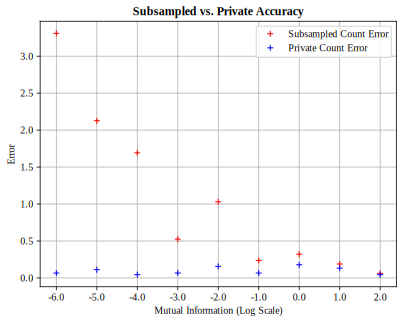

In [16]:
# Accuracy Plot

import matplotlib.pyplot as plt

# Plot
plt.figure()
plt.plot(budget_list, private_error, 'r+', label='Subsampled Count Error')  
plt.plot(budget_list, subsampled_error, 'b+', label='Private Count Error')

plt.xscale('log', base=2)
plt.xticks(budget_list, [format(np.log2(val)) for val in budget_list])

plt.xlabel('Mutual Information (Log Scale)')
plt.ylabel('Error')

plt.title('Subsampled vs. Private Accuracy')
plt.legend()

plt.grid(True)

folder_path = 'figs/student_performance'
plt.savefig(folder_path + '/skewed_count_error.png')
plt.show()

# Observation - the subsampled accuracy itself falls, but PAC holds...


## Multiple Predicates - Apply first

In [60]:
# Non-private query
from pyspark.sql.functions import sum as spark_sum

empty_result_set = math_df.filter((math_df["absences"] > 10) & (math_df["Mjob"] == "at_home")).count()

print(empty_result_set)

8


In [61]:
# Private Query

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions, BudgetAccountant
import paclib.mechanism
import math

user_defined_sampling_rate = 0.5
# tau = 3
# seeds =  list(range(tau))
budget_list = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]
m = 50
c = 1e-6

def create_pac_df(df, user_defined_sampling_rate, seed=None):

    pac_defaulters_df = (PACDataFrame(df)
                    .withSamplerOptions(
                        SamplerOptions(
                            withReplacement=False,                  # should be false given get_samples_safe() logic 
                                                                    #    - perhaps no custom input for this?
                            fraction=user_defined_sampling_rate,    # fixed sampling rate of 0.5
                            columns_to_sample_by=None,
                            seed=seed
                        )
                    ))
    return pac_defaulters_df

def estimate_noise(df, user_defined_sampling_rate, m, seeds=None):
    # for each trial, get Y1, Y2 and Y3 for every seed
    min_distances = []
    for _ in range(m): 
        y_1 = []
        y_2 = []
        print("trial ", _)
        # for seed in range(len(seeds)):
        pac_defaulters_df = create_pac_df(df, user_defined_sampling_rate, seed=None)
    
        # given X1 and X2 of the same seed, apply A(X) to produce Yi where i is the ith seed
        y_i_1 = (pac_defaulters_df.sample()
            .filter((df["absences"] > 10) & (df["Mjob"] == "at_home"))).count()
        y_i_2 = (pac_defaulters_df.sample()
                .filter((df["absences"] > 10) & (df["Mjob"] == "at_home"))).count()

        y_i_1 *= (1/user_defined_sampling_rate)
        y_i_2 *= (1/user_defined_sampling_rate)

        print("For current trial ", _, " the values are ", y_i_1, y_i_2)

        y_1.append(y_i_1)
        y_2.append(y_i_2)
            
        # find average minimum perturbation distance between y1 and y2 - the paper uses euclidean distance
        # for ind in range(tau):
        current_distance = np.linalg.norm(np.array(y_i_1) - np.array(y_i_2))
        print("Current distance ", current_distance)
        min_distances.append(current_distance)
        
    # Calculate average minimum perturbation distance
    avg_min_distance = np.mean(min_distances) # this will divide by m trials
    return avg_min_distance

avg_min_distance = estimate_noise(math_df, user_defined_sampling_rate, m)
print(avg_min_distance)


trial  0
For current trial  0  the values are  2.0 6.0
Current distance  4.0
trial  1
For current trial  1  the values are  4.0 12.0
Current distance  8.0
trial  2
For current trial  2  the values are  8.0 8.0
Current distance  0.0
trial  3
For current trial  3  the values are  4.0 12.0
Current distance  8.0
trial  4
For current trial  4  the values are  8.0 6.0
Current distance  2.0
trial  5
For current trial  5  the values are  4.0 10.0
Current distance  6.0
trial  6
For current trial  6  the values are  6.0 12.0
Current distance  6.0
trial  7
For current trial  7  the values are  8.0 8.0
Current distance  0.0
trial  8
For current trial  8  the values are  6.0 6.0
Current distance  0.0
trial  9
For current trial  9  the values are  8.0 10.0
Current distance  2.0
trial  10
For current trial  10  the values are  6.0 4.0
Current distance  2.0
trial  11
For current trial  11  the values are  8.0 6.0
Current distance  2.0
trial  12
For current trial  12  the values are  10.0 4.0
Current d

In [62]:
final_results = []
subsampled_error = []

actual_result = 8

for budget_item in budget_list:
    budget = BudgetAccountant(max_mi=budget_item)
    print("For current MI value,", budget_item)
    # using the distance, calculate exact noise as isotropic Gaussian noise with mean 0 and variance as avg_min_distance
    noise = paclib.mechanism.noise_to_add(avg_min_distance, c, budget)
    print("Noise computed to be - ", noise)

    # compute final sample for different mi's
    pac_defaulters_df = create_pac_df(math_df, user_defined_sampling_rate, seed=None)
    
    y_final = (pac_defaulters_df.sample()
                .filter((math_df["absences"] > 10) & (math_df["Mjob"] == "at_home"))).count()
    
    y_final *= (1/user_defined_sampling_rate)

    print("subsampled count is ", y_final)
    
    error_of_subsampled = abs(actual_result - y_final)/actual_result
    subsampled_error.append(error_of_subsampled)

    y_final += abs(noise)
    print("private count is ", y_final)

    final_results.append(y_final)

For current MI value, 0.015625
Noise computed to be -  -499.26163317059144
subsampled count is  12.0
private count is  511.26163317059144
For current MI value, 0.03125
Noise computed to be -  77.76389305189274
subsampled count is  16.0
private count is  93.76389305189274
For current MI value, 0.0625
Noise computed to be -  -46.467009914207395
subsampled count is  8.0
private count is  54.467009914207395
For current MI value, 0.125
Noise computed to be -  -54.6575240994656
subsampled count is  4.0
private count is  58.6575240994656
For current MI value, 0.25
Noise computed to be -  0.6190020987824699
subsampled count is  2.0
private count is  2.61900209878247
For current MI value, 0.5
Noise computed to be -  -2.0223710095893153
subsampled count is  12.0
private count is  14.022371009589316
For current MI value, 1.0
Noise computed to be -  0.8054903996259809
subsampled count is  8.0
private count is  8.805490399625981
For current MI value, 2.0
Noise computed to be -  1.150773175487027
su

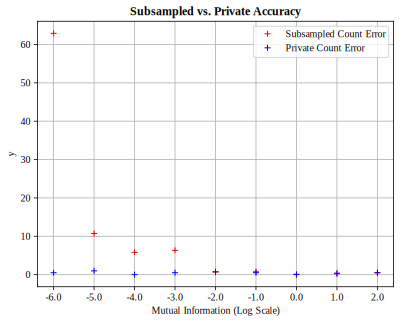

In [63]:
# Accuracy Plot
import math
private_error = []
for y in final_results:
    priv_result = abs(actual_result - y)/actual_result
    private_error.append(priv_result)

import matplotlib.pyplot as plt

# Plot
plt.figure()
plt.plot(budget_list, private_error, 'r+', label='Subsampled Count Error')  
plt.plot(budget_list, subsampled_error, 'b+', label='Private Count Error')

plt.xscale('log', base=2)
plt.xticks(budget_list, [format(np.log2(val)) for val in budget_list])

plt.xlabel('Mutual Information (Log Scale)')
plt.ylabel('y')
plt.title('Subsampled vs. Private Accuracy')
plt.legend()

plt.grid(True)
plt.show()

## Multiple Predicates - Apply 1 filter, sample, then apply next filter

In [64]:
# Private Query

from pacdb import PACDataFrame, Sampler, DataFrameSampler, SamplerOptions, BudgetAccountant
import paclib.mechanism
import math

user_defined_sampling_rate = 0.5
# tau = 3
# seeds =  list(range(tau))
budget_list = [1/64, 1/32, 1/16, 1/8, 1/4, 1/2, 1., 2., 4.]
m = 50
c = 1e-6

def create_pac_df(df, user_defined_sampling_rate, seed=None):

    pac_defaulters_df = (PACDataFrame(df)
                    .withSamplerOptions(
                        SamplerOptions(
                            withReplacement=False,                  # should be false given get_samples_safe() logic 
                                                                    #    - perhaps no custom input for this?
                            fraction=user_defined_sampling_rate,    # fixed sampling rate of 0.5
                            columns_to_sample_by=None,
                            seed=seed
                        )
                    ))
    return pac_defaulters_df

def estimate_noise(df, user_defined_sampling_rate, m, seeds=None):
    # for each trial, get Y1, Y2 and Y3 for every seed
    min_distances = []
    for _ in range(m): 
        y_1 = []
        y_2 = []
        print("trial ", _)
        # for seed in range(len(seeds)):
        pac_defaulters_df = create_pac_df(df, user_defined_sampling_rate, seed=None)
    
        # given X1 and X2 of the same seed, apply A(X) to produce Yi
        y_i_1 = (pac_defaulters_df.sample()
                .filter((df["Mjob"] == "at_home"))).count()
        y_i_2 = (pac_defaulters_df.sample()
                .filter((df["Mjob"] == "at_home"))).count()

        y_i_1 *= (1/user_defined_sampling_rate)
        y_i_2 *= (1/user_defined_sampling_rate)

        print("For current trial ", _, " the values are ", y_i_1, y_i_2)

        y_1.append(y_i_1)
        y_2.append(y_i_2)
            
        # find average minimum perturbation distance between y1 and y2 - the paper uses euclidean distance
        # for ind in range(tau):
        current_distance = np.linalg.norm(np.array(y_i_1) - np.array(y_i_2))
        print("Current distance ", current_distance)
        min_distances.append(current_distance)
        
    # Calculate average minimum perturbation distance
    avg_min_distance = np.mean(min_distances) # this will divide by m trials
    return avg_min_distance

avg_min_distance = estimate_noise(math_df.filter(math_df["absences"] > 10), user_defined_sampling_rate, m)
print(avg_min_distance)


trial  0
For current trial  0  the values are  8.0 6.0
Current distance  2.0
trial  1
For current trial  1  the values are  6.0 10.0
Current distance  4.0
trial  2
For current trial  2  the values are  8.0 12.0
Current distance  4.0
trial  3
For current trial  3  the values are  6.0 10.0
Current distance  4.0
trial  4
For current trial  4  the values are  6.0 6.0
Current distance  0.0
trial  5
For current trial  5  the values are  8.0 14.0
Current distance  6.0
trial  6
For current trial  6  the values are  2.0 6.0
Current distance  4.0
trial  7
For current trial  7  the values are  10.0 2.0
Current distance  8.0
trial  8
For current trial  8  the values are  10.0 4.0
Current distance  6.0
trial  9
For current trial  9  the values are  6.0 12.0
Current distance  6.0
trial  10
For current trial  10  the values are  12.0 10.0
Current distance  2.0
trial  11
For current trial  11  the values are  10.0 8.0
Current distance  2.0
trial  12
For current trial  12  the values are  4.0 8.0
Curre

In [65]:
final_results = []
subsampled_error = []

actual_result = 8
math_df_filtered = math_df.filter(math_df["absences"] > 10)

for budget_item in budget_list:
    budget = BudgetAccountant(max_mi=budget_item)
    print("For current MI value,", budget_item)
    # using the distance, calculate exact noise as isotropic Gaussian noise with mean 0 and variance as avg_min_distance
    noise = paclib.mechanism.noise_to_add(avg_min_distance, c, budget)
    print("Noise computed to be - ", noise)

    # compute final sample for different mi's
    pac_defaulters_df = create_pac_df(math_df_filtered, user_defined_sampling_rate, seed=None)
    
    y_final = (pac_defaulters_df.sample()
                .filter((math_df["Mjob"] == "at_home"))).count()
    
    y_final *= (1/user_defined_sampling_rate)

    print("subsampled count is ", y_final)
    
    error_of_subsampled = abs(actual_result - y_final)/actual_result
    subsampled_error.append(error_of_subsampled)

    y_final += abs(noise)
    print("private count is ", y_final)

    final_results.append(y_final)

For current MI value, 0.015625
Noise computed to be -  286.50143422400305
subsampled count is  8.0
private count is  294.50143422400305
For current MI value, 0.03125
Noise computed to be -  2.006780587639483
subsampled count is  6.0
private count is  8.006780587639483
For current MI value, 0.0625
Noise computed to be -  12.70481367147562
subsampled count is  10.0
private count is  22.70481367147562
For current MI value, 0.125
Noise computed to be -  25.25417209136789
subsampled count is  10.0
private count is  35.25417209136789
For current MI value, 0.25
Noise computed to be -  14.110656698137102
subsampled count is  8.0
private count is  22.110656698137102
For current MI value, 0.5
Noise computed to be -  13.321717287216673
subsampled count is  8.0
private count is  21.32171728721667
For current MI value, 1.0
Noise computed to be -  -4.703820477167492
subsampled count is  4.0
private count is  8.703820477167492
For current MI value, 2.0
Noise computed to be -  -2.3320514671209707
subs

## Mean

PAC-count / PAC-sum vs PAC-mean

## Var

σ^2=n∑i=1 ​(xi​−x)^2 / n 

(Chorus does not implement variance---find out why?)​